In [30]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import root
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
data_dir = "hubbard_dmrg_3_new"
exact_file = "hubbard_exact.hdf5"
l = 3
output_filename = f"hubbard_{l}_error_ut_2_new.pdf"
d_max = 30
d_min = 3

if l == 2:
    num_cnot = 22
elif l == 3:
    num_cnot = 191
elif l == 4:
    num_cnot = 472
else:
    raise ValueError(f"Invalid dimension {l}")

In [32]:
all_files = os.listdir(data_dir)
assert exact_file in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [33]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/" + exact_file, "r")
energy_exact = f_exact["energy"][()]
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is -2.123105625641709.


In [34]:
# subspace_files = [f for f in all_files if "subspace" in f]
# for i in range(len(subspace_files)):
#     f_subspace = h5py.File(data_dir + "/" + subspace_files[i])
#     ref_energy = f_subspace["reference_energy"][()]
#     f_subspace.close()
#     print(f"Reference energy = {ref_energy}")

In [35]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact)
    df["steps"] = steps
    df["num_2q"] = steps * num_cnot
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps    energy  num_pos     error  steps  num_2q
i                                                               
0    3  1.000000e-08 -2.051859        3  0.071246     50    9550
1    4  1.000000e-08 -2.075241        4  0.047865     50    9550
2    5  1.000000e-08 -2.095967        5  0.027139     50    9550
3    6  1.000000e-08 -2.103243        6  0.019863     50    9550
4    7  1.000000e-08 -2.107122        6  0.015984     50    9550
..  ..           ...       ...      ...       ...    ...     ...
9   12  1.000000e-08 -2.110925        8  0.012181     10    1910
10  13  1.000000e-08 -2.112738        9  0.010368     10    1910
11  14  1.000000e-08 -2.114138        9  0.008968     10    1910
12  15  1.000000e-08 -2.115309        9  0.007797     10    1910
13  16  1.000000e-08 -2.116287       10  0.006819     10    1910

[154 rows x 7 columns]


In [36]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

Empty DataFrame
Columns: [d, eps, energy, num_pos, error, steps, num_2q]
Index: []


In [37]:
df_inter = df_total[df_total["d"] <= d_max]
df_small = df_inter[df_inter["d"] >= d_min]
print(df_small.head())

   d           eps    energy  num_pos     error  steps  num_2q
i                                                             
0  3  1.000000e-08 -2.051859        3  0.071246     50    9550
1  4  1.000000e-08 -2.075241        4  0.047865     50    9550
2  5  1.000000e-08 -2.095967        5  0.027139     50    9550
3  6  1.000000e-08 -2.103243        6  0.019863     50    9550
4  7  1.000000e-08 -2.107122        6  0.015984     50    9550


In [38]:
chemical_accuracy = 0.00159 * l ** 2
print(f"Chemical accuracy is {chemical_accuracy} ha.")

Chemical accuracy is 0.01431 ha.


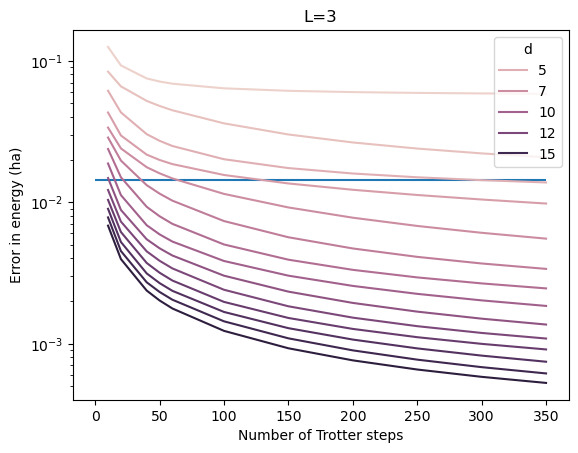

In [39]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.hlines(chemical_accuracy, 0, 350)
sns.lineplot(ax=ax, data=df_small, x="steps", y="error", hue="d")
# plt.ylim(top=chemical_accuracy+ 0.01)
ax.set_xlabel("Number of Trotter steps")
ax.set_ylabel("Error in energy (ha)")
plt.title(f"L={l}")
plt.savefig(output_filename)

In [40]:
def find_num_steps(steps, errors, accuracy, t0):
    """Find the number of steps for a given accuracy by interpolation."""

    assert np.min(errors) <= accuracy <= np.max(errors),\
        f"Accuracy {accuracy} must be between {np.min(errors)} and {np.max(errors)}"
    spline = CubicSpline(steps, errors)
    solution = root(lambda nt: spline(nt) - accuracy, t0)
    if not solution.success:
        print("Solver did not converge.")
    return solution.x

In [41]:
for d in range(3, 17):
    df_d = df_total[df_total["d"] == d]
    errors = df_d["error"].to_numpy()
    print(d, np.min(errors), np.max(errors))

3 0.058324661089124596 0.12515512819490415
4 0.020734692555334 0.08363355529978334
5 0.013774888067922486 0.06130610214778498
6 0.009772159886753506 0.04302419264935642
7 0.005518056561522489 0.03365101550116245
8 0.003371890698546931 0.02862290900843778
9 0.002454278354658168 0.023765291140012135
10 0.001845016567196378 0.01875192111446955
11 0.0013624661378597303 0.01481143873571611
12 0.0010849908666554775 0.01218078413884438
13 0.0009084959192442454 0.010367852199053118
14 0.0007437077874929976 0.0089677999840716
15 0.0006146334180807678 0.007796837963212067
16 0.0005266392694975863 0.006818750537540552


In [42]:
# For each given error, find how many steps it would take to produce, along wih the required d.
errs = [0.1, 0.1, 1e-2, 1e-2, 1e-2, 1e-3, 5e-4]
ds = [3, 4, 7, 8, 9, 14, 15]
nt0 = [50, 50, 250, 200, 200, 200, 200] # Guess at number of steps.

for err, d, nt in zip(errs, ds, nt0):
    df_d = df_total[df_total["d"] == d]
    df_d.sort_values("steps", inplace=True)
    errors = df_d["error"].to_numpy()
    steps = df_d["steps"].to_numpy()
    steps = find_num_steps(steps, errors, err, nt)
    print(err, d, steps)

0.1 3 [16.95387594]


/var/folders/rv/3v7hvpgn6ks14zr4w90jz4zc0000gn/T/ipykernel_9015/1125365208.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d.sort_values("steps", inplace=True)


AssertionError: Accuracy 0.1 must be between 0.020734692555334 and 0.08363355529978334